# Medical Expenditure Tutorial

## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms . It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

Classifiers are built using Logistic Regression as well as Random Forests.

Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.

Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).

Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial. See [Section 2](#2.-Data-used) below for more details.


## Table of Contents

To return to the table of contents, click on the number at any major section heading.

[1. Use case](#1.-Use-case)

[2. Data used](#2.-Data-used)

[3. Training models without debiasing](#3.-Training-models-on-original-2015-Panel-19-data)

[4. Reweighing (pre-processing bias mitigation)](#4.-Bias-mitigation-using-pre-processing-technique---Reweighing)

[5. Prejudice Remover (in-processing bias mitigation)](#5.-Bias-mitigation-using-in-processing-technique---Prejudice-Remover-(PR))

[6. Summary of results](#6.-Summary-of-Model-Learning-Results)

[7. Deploying model](#7.-Deploying-model)

[8. Generating explanations for model predictions using LIME](#8.-Generating-explanations-for-model-predictions-using-LIME)

[9. Re-deploying Model](#9.-Re-deploying-Model)

[10. Overall Summary](#10.-SUMMARY)

## [1.](#Table-of-Contents) Use case

In order to demonstrate how AIF 360 can be used to detect and mitigate bias in classfier models, we adopt the following use case:

1. a data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.


2. developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.


3. the app is put into production and starts scoring people and making recommendations. 


4. explanations are generated for each recommendation


5. both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.


6. nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.


7. when significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

## [2.](#Table-of-Contents) Data used

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

For this demonstration, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.

The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data. (Use case steps 1-2.)
It is then put into practice and used to score people to identify potential candidates for care management (Use case steps 3-5). Initial deployment is simulated to 2015 Panel 20 deployment data. To show change in performance and/or fairness over time, (use case steps 6-7), the 2016 Panel 21 deployment data is used. Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

## [3.](#Table-of-Contents) Training models on original 2015 Panel 19 data

First, load all necessary packages

In [2]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [38]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

In [124]:
dataset_orig_panel19_test.protected_attributes[:, 0]

array([1., 0., 1., ..., 0., 0., 1.])

In [131]:
import pandas as pd
dataset_orig_panel19_test.convert_to_dataframe()[0]["RACE"]

7622     1.0
7475     0.0
9258     1.0
1923     0.0
4323     1.0
        ... 
8026     0.0
13921    0.0
7306     0.0
9231     0.0
10042    1.0
Name: RACE, Length: 3166, dtype: float64

This function will be used throughout the notebook to print out some labels, names, etc.

In [6]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Show 2015 dataset details

In [7]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [8]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


### 3.2. Learning a Logistic Regression (LR) classifier on original data

#### 3.2.1. Training LR model on original data

In [9]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [108]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [109]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.02887301841686235
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.06128967124619672
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.11465939907034167
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.1504407002447402
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.18968368243570144
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.21471449567433967
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.22186542409983545
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.226744315737997
Average odds difference (average of TPR difference and FPR difference, 0 = equality

Plot metrics with twin x-axes

In [12]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot $1 - \min(\text{disparate impact}, 1/\text{disparate impact})$ since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

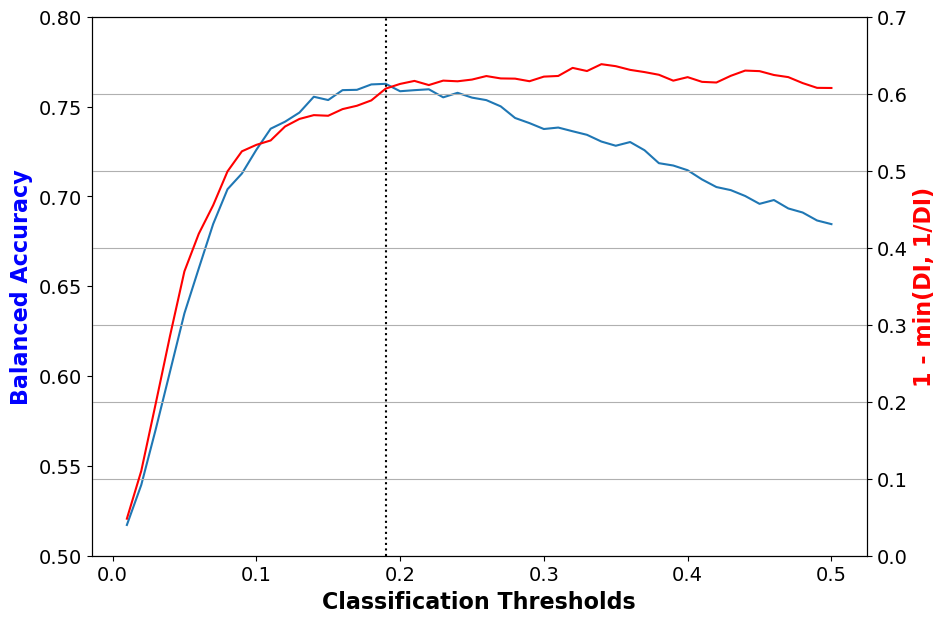

In [13]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

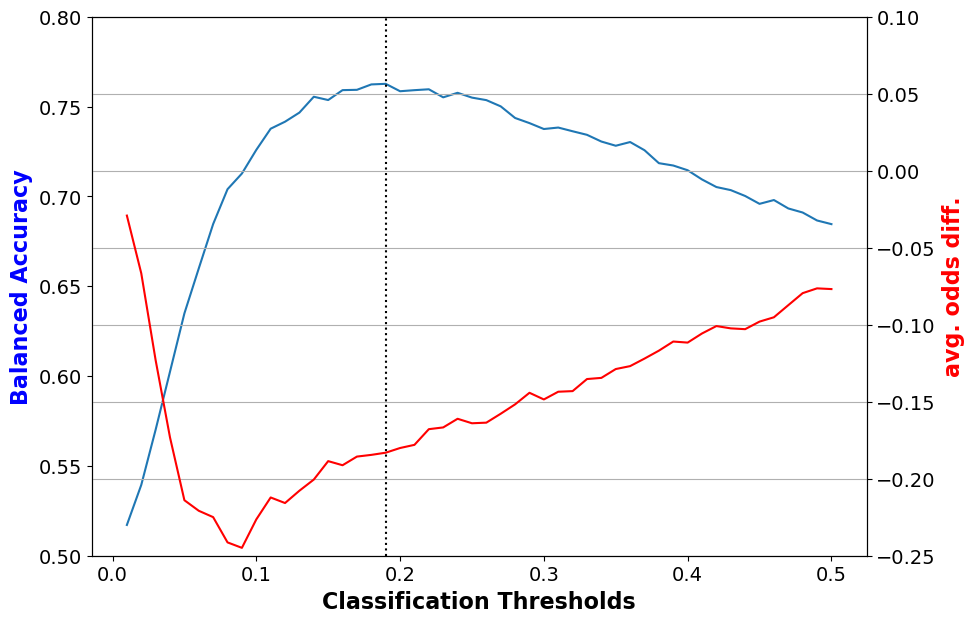

In [14]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Make a function to print out accuracy and fairness metrics. This will be used throughout the tutorial.

In [15]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [16]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


#### 3.2.3. Testing LR model on original data

In [17]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [18]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, $\text{average odds difference} = \frac{(FPR_{unpriv}-FPR_{priv})+(TPR_{unpriv}-TPR_{priv})}{2}$ must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.

### 3.3. Learning a Random Forest (RF) classifier on original data

#### 3.3.1. Training RF model on original data

In [19]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 3.3.2. Validating RF model on original data

In [20]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

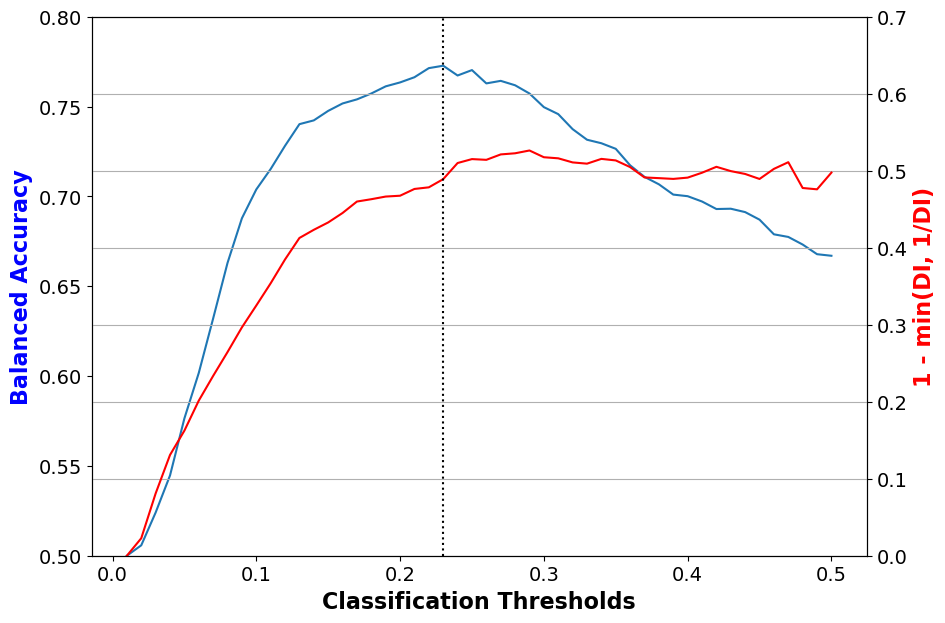

In [21]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

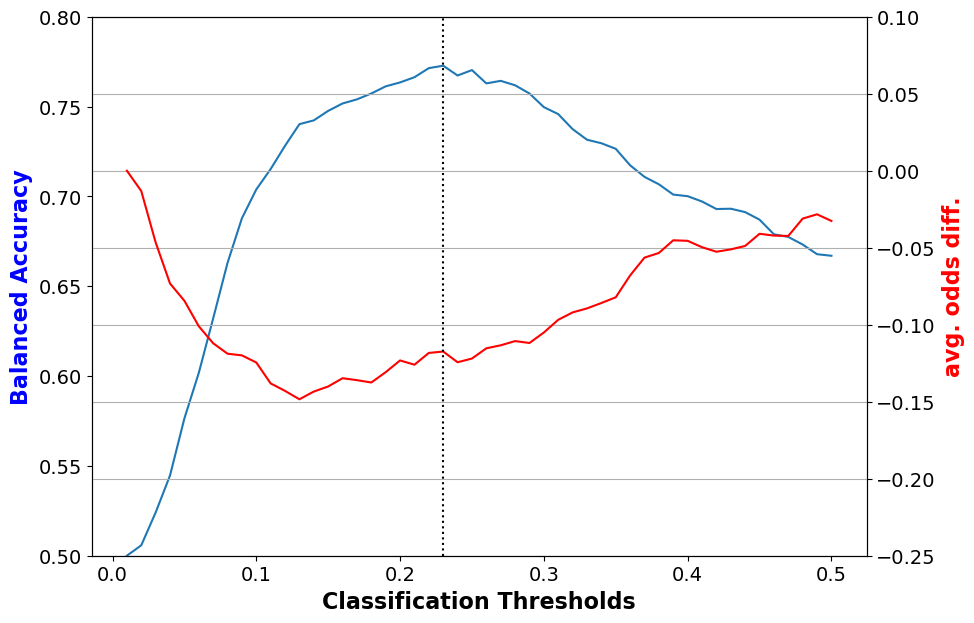

In [22]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [23]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


#### 3.3.3. Testing RF model on original data

In [24]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [25]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


As in the case of the logistic regression classifier learned on the original data, the fairness metrics for the random forest classifier have values that are quite far from 0.

For example, 1 - min(DI, 1/DI) has a value of over 0.5 as opposed to the desired value of < 0.2.

This indicates that the random forest classifier learned on the original data is also unfair.

## [4.](#Table-of-Contents) Bias mitigation using pre-processing technique - Reweighing

### 4.1. Transform data

In [28]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

Metrics for transformed data

In [29]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


### 4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing

#### 4.2.1. Training LR model after reweighing

In [44]:
dataset.instance_weights

array([15766.29673286, 14501.27316644,     0.        , ...,
        3397.717385  ,  6208.53055615,  8951.98767226])

In [48]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.2.2. Validating  LR model after reweighing

In [31]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

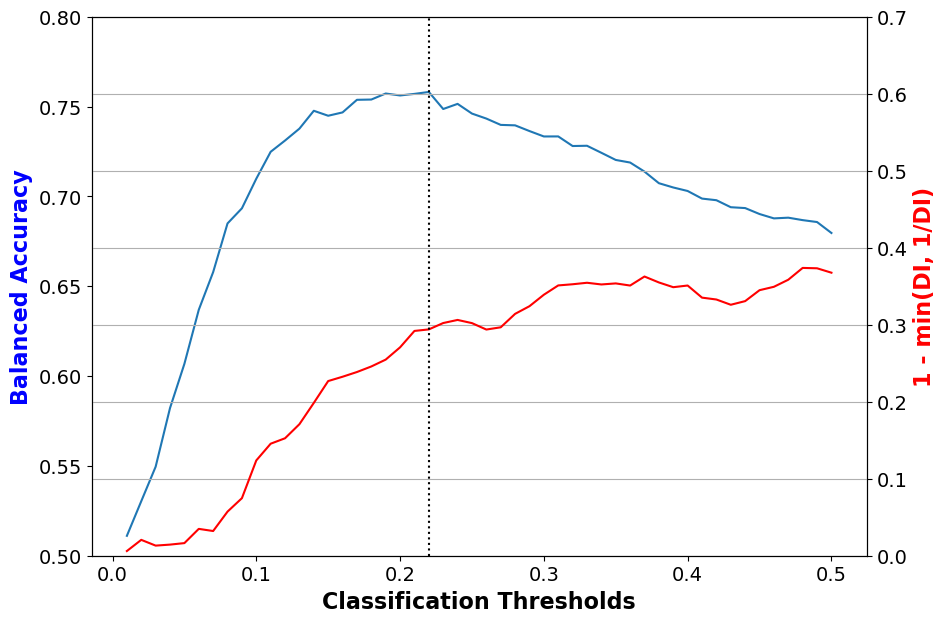

In [32]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

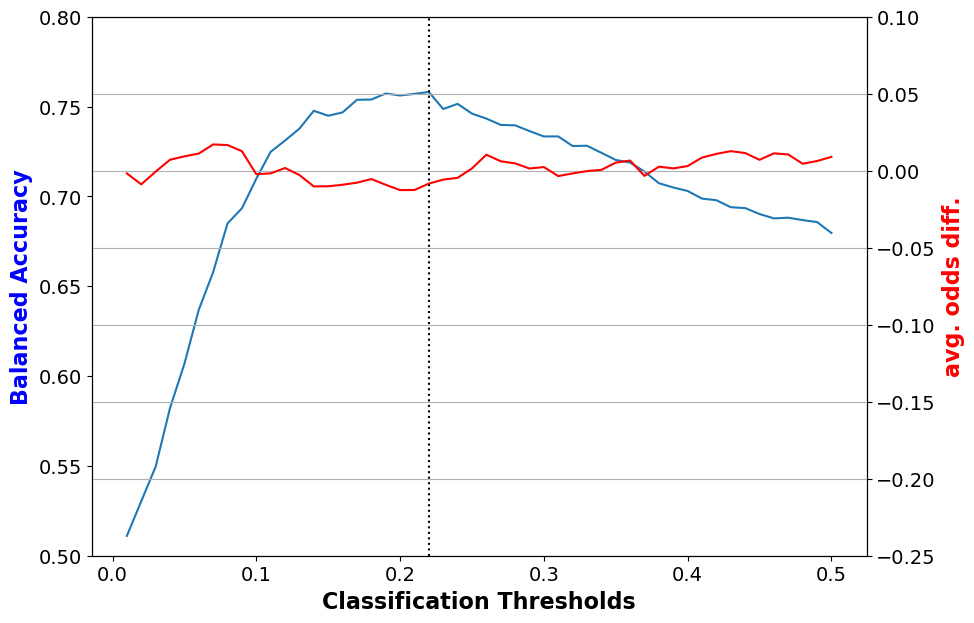

In [33]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [34]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding 1-min(DI, 1/DI) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


#### 4.2.3. Testing  LR model after reweighing

In [35]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [36]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding 1-min(DI, 1/DI) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


The fairness metrics for the logistic regression model learned after reweighing are well improved, and thus the model is much more fair relative to the logistic regression model learned from the original data.

### 4.3. Learning a Random Forest (RF) classifier on data transformed by reweighing

#### 4.3.1. Training  RF model after reweighing

In [37]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.3.2. Validating  RF model after reweighing

In [39]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

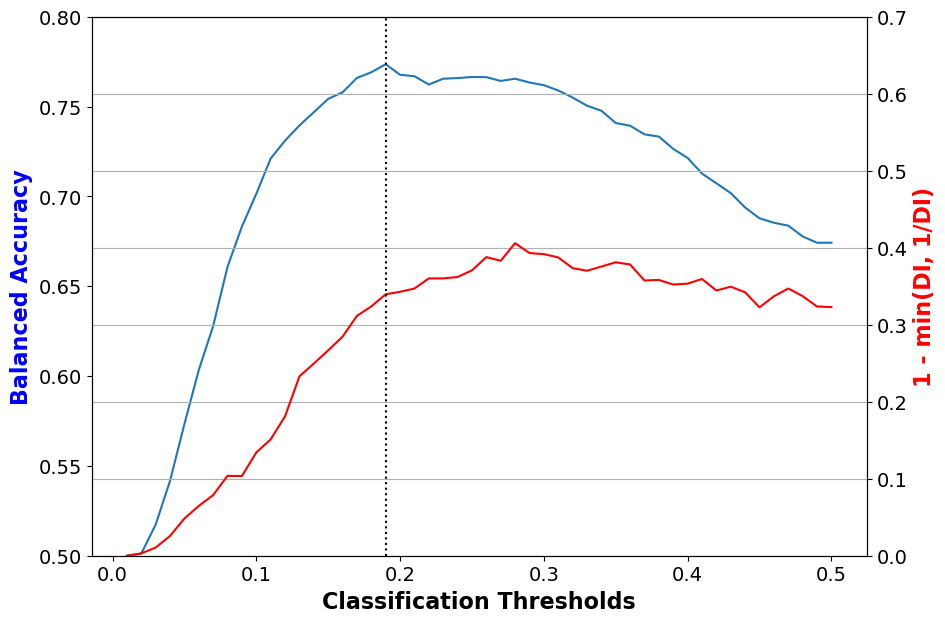

In [51]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

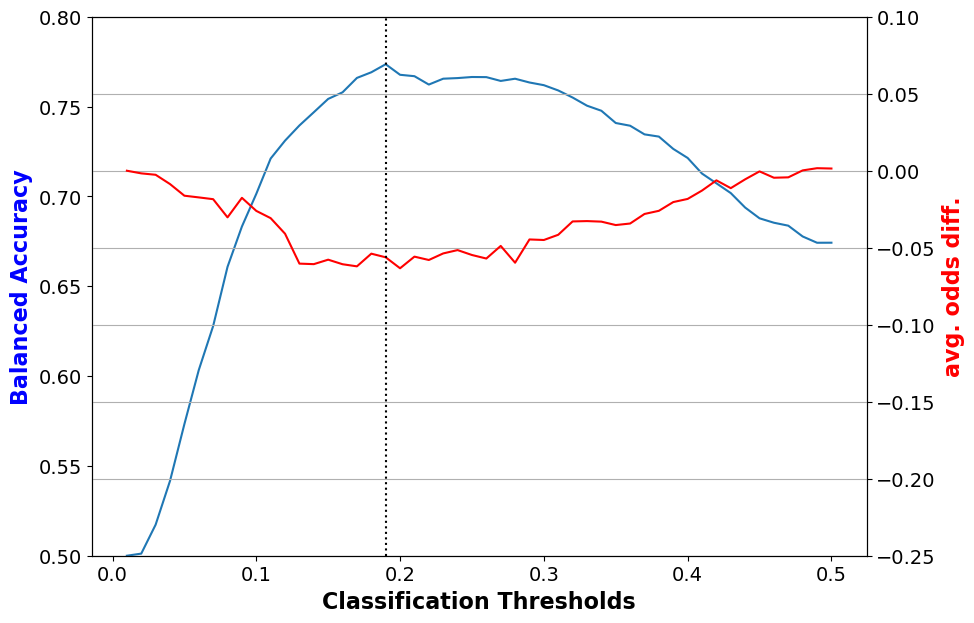

In [52]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [53]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7736
Corresponding 1-min(DI, 1/DI) value: 0.3395
Corresponding average odds difference value: -0.0562
Corresponding statistical parity difference value: -0.1523
Corresponding equal opportunity difference value: 0.0017
Corresponding Theil index value: 0.0848


#### 4.3.3. Testing  RF model after reweighing

In [54]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [55]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7689
Corresponding 1-min(DI, 1/DI) value: 0.3779
Corresponding average odds difference value: -0.0795
Corresponding statistical parity difference value: -0.1688
Corresponding equal opportunity difference value: -0.0614
Corresponding Theil index value: 0.0867


Once again, the model learned from the transformed data is fairer than that learned from the original data. However, the random forest model learned from the transformed data is still relatively unfair as compared to the logistic regression model learned from the transformed data.

## [5.](#Table-of-Contents) Bias mitigation using in-processing technique - Prejudice Remover (PR)

### 5.1. Learning a Prejudice Remover (PR) model on original data

#### 5.1.1. Training a PR model

In [56]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

#### 5.1.2. Validating PR model

In [57]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

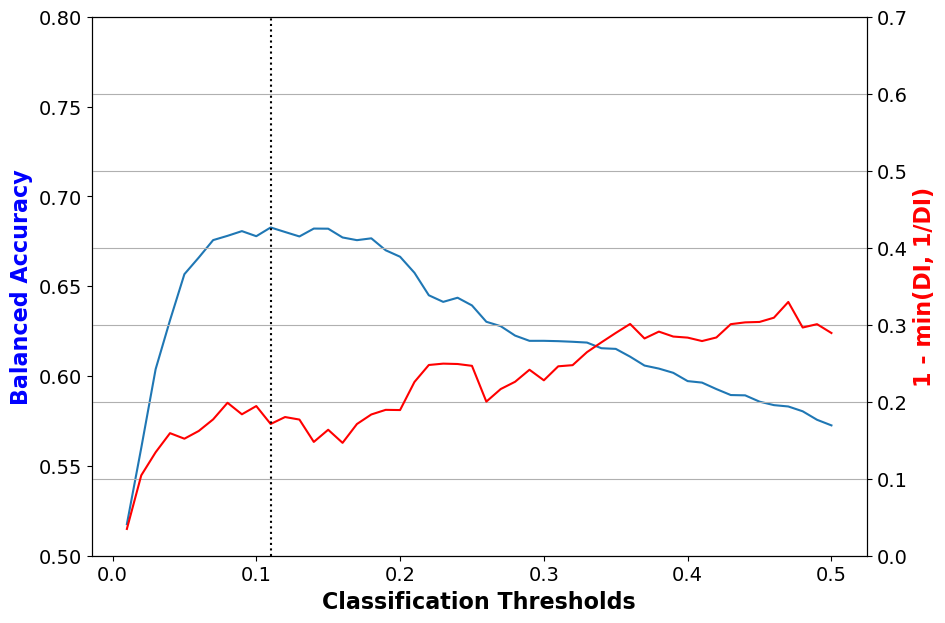

In [58]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

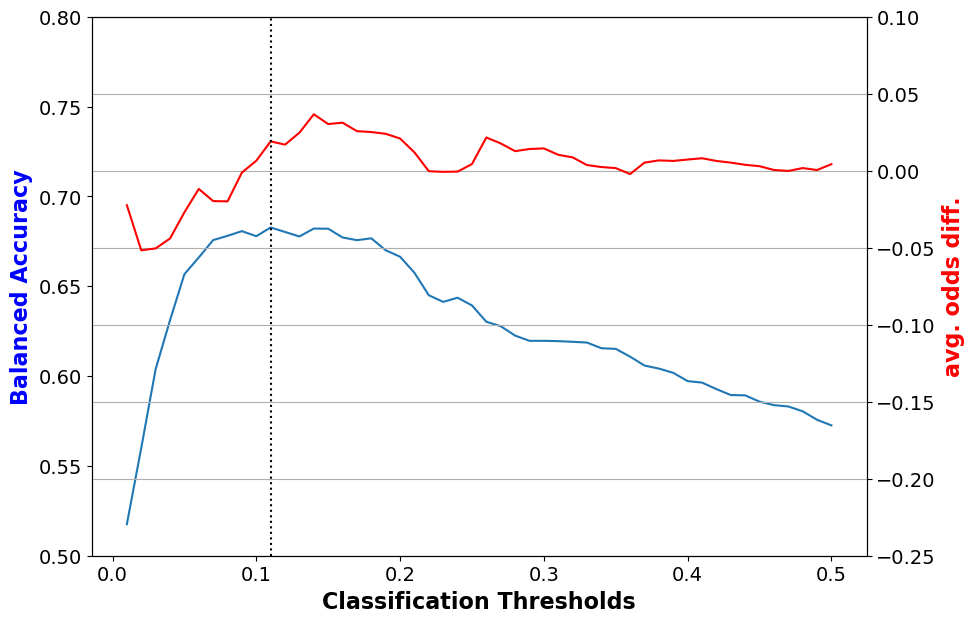

In [59]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [60]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1100
Best balanced accuracy: 0.6827
Corresponding 1-min(DI, 1/DI) value: 0.1711
Corresponding average odds difference value: 0.0190
Corresponding statistical parity difference value: -0.0629
Corresponding equal opportunity difference value: 0.0847
Corresponding Theil index value: 0.1120


#### 5.1.3. Testing PR model

In [61]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [62]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1100
Best balanced accuracy: 0.6872
Corresponding 1-min(DI, 1/DI) value: 0.2506
Corresponding average odds difference value: -0.0250
Corresponding statistical parity difference value: -0.1037
Corresponding equal opportunity difference value: 0.0122
Corresponding Theil index value: 0.1105


As in the case of reweighing, prejudice remover results in a fair model. However, it has come at the expense of relatively lower balanced accuracy.

## [6.](#Table-of-Contents) Summary of Model Learning Results

In [63]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, rf_orig_metrics, lr_transf_metrics,
           rf_transf_metrics, pr_orig_metrics]
debias = pd.Series(['']*2 + ['Reweighing']*2
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression', 'Random Forest']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.775935,-0.205706,0.426176,-0.261207,-0.222779,0.092122
,Random Forest,0.764042,-0.134638,0.495973,-0.212121,-0.114076,0.094373
Reweighing,Logistic Regression,0.753893,-0.015104,0.751755,-0.087196,-0.003518,0.096575
Reweighing,Random Forest,0.768890,-0.079471,0.622080,-0.168814,-0.061399,0.086749
Prejudice Remover,,0.687161,-0.025024,0.749361,-0.103694,0.012224,0.110482


Of all the models, the logistic regression model gives the best balance in terms of balanced accuracy and fairness. While the model learnt by prejudice remover is slightly fairer, it has much lower accuracy. All other models are quite unfair compared to the logistic model. Hence, we take the logistic regression model learnt from data transformed by re-weighing and 'deploy' it.

## [7.](#Table-of-Contents) Deploying model

### 7.1. Testing model learned on 2014 (Panel 19) on 2015 (Panel 20) deployment data

In [64]:
dataset_orig_panel20_deploy = MEPSDataset20()

# now align it with the 2014 dataset
dataset_orig_panel20_deploy = dataset_orig_panel19_train.align_datasets(dataset_orig_panel20_deploy)

In [65]:
# describe(dataset_orig_panel20_train, dataset_orig_panel20_val, dataset_orig_panel20_deploy)
describe(test=dataset_orig_panel20_deploy)

#### Test Dataset shape

(17570, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [66]:
metric_orig_panel20_deploy = BinaryLabelDatasetMetric(
        dataset_orig_panel20_deploy, 
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel20_deploy = MetricTextExplainer(metric_orig_panel20_deploy)

print(explainer_orig_panel20_deploy.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5456992351196291


In [67]:
lr_transf_metrics_panel20_deploy = test(
        dataset=dataset_orig_panel20_deploy,
        model=lr_transf_panel19,
        thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [68]:
describe_metrics(lr_transf_metrics_panel20_deploy, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7311
Corresponding 1-min(DI, 1/DI) value: 0.1943
Corresponding average odds difference value: 0.0071
Corresponding statistical parity difference value: -0.0596
Corresponding equal opportunity difference value: 0.0303
Corresponding Theil index value: 0.1019


Deployed model tested on the 2015 Panel 20 data still exhibits fairness as well as maintains accuracy.

## [8.](#Table-of-Contents) Generating explanations for model predictions using LIME

### 8.1. Generating explanations on 2015 Panel 20 deployment data

This section shows how LIME can be integrated with AIF360 to get explanations for model predictions.

In [69]:
train_dataset = dataset_transf_panel19_train  # data the deployed model (lr from transformed data)
test_dataset = dataset_orig_panel20_deploy  # the data model is being tested on
model = lr_transf_panel19  # lr_transf_panel19 is LR model learned from Panel 19 with Reweighing
thresh_arr = np.linspace(0.01, 0.5, 50)
best_thresh = thresh_arr[lr_transf_best_ind]

First, we need to fit the encoder to the aif360 dataset

In [70]:
lime_data = LimeEncoder().fit(train_dataset)

The `transform()` method is then used to convert aif360 features to LIME-compatible features

In [71]:
s_train = lime_data.transform(train_dataset.features)
s_test = lime_data.transform(test_dataset.features)

The `LimeTabularExplainer` takes as input the LIME-compatible data along with various other arguments to create a lime explainer

In [72]:
explainer = LimeTabularExplainer(
        s_train, class_names=lime_data.s_class_names, 
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features, 
        categorical_names=lime_data.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)

The `inverse_transform()` function is used to transform LIME-compatible data back to aif360-compatible data since that is needed by the model to make predictions. The function below is used to produce the predictions for any perturbed data that is produce by LIME

In [73]:
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))

The `explain_instance()` method can then be used to produce explanations for any instance in the test dataset

In [74]:
def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=10)
    print("Actual label: " + str(test_dataset.labels[ind]))
    exp.as_pyplot_figure()
    plt.show()

Threshold corresponding to Best balanced accuracy: 0.2200
Actual label: [0.]


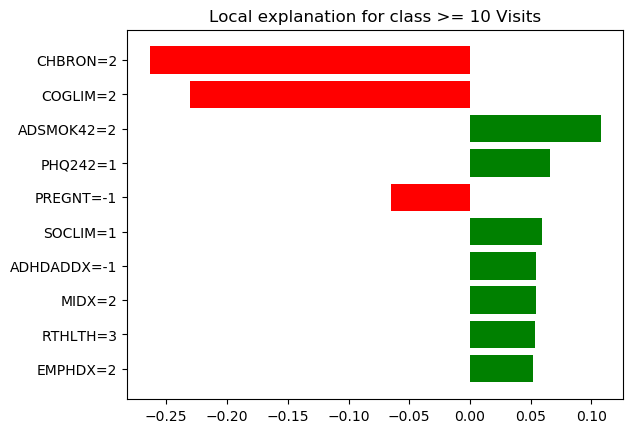

Actual label: [0.]


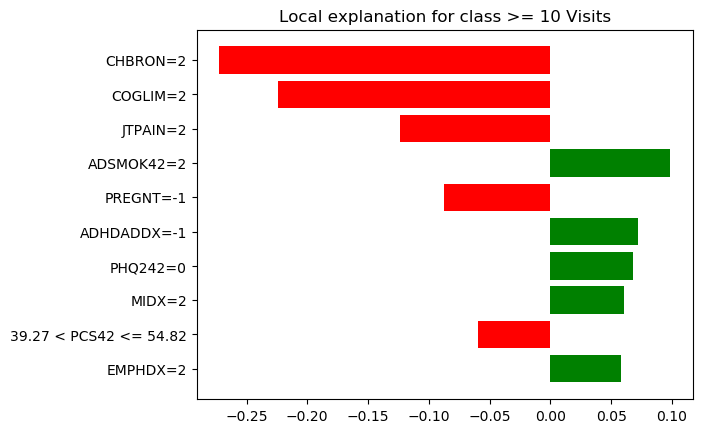

In [75]:
print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(best_thresh))
show_explanation(0)
show_explanation(2)

See the [LIME documentation](https://github.com/marcotcr/lime) for detailed description of results. In short, the left hand side shows the label predictions made by the model, the middle shows the features that are important to the instance in question and their contributions (weights) to the label prediction, while the right hand side shows the actual values of the features in the particular instance.

## [9.](#Table-of-Contents) Re-deploying Model

### 9.1. Testing model learned on 2014 (Panel 19) data on 2016 (Panel 21) deployment data

Load the Panel 21 data, and split it again into 3 parts: train, validate, and deploy. We test the deployed model against the deployment data. If a new model needs to be learnt, it will be learnt from the train/validate data and then tested again on the deployment data.

In [76]:
dataset_orig_panel21_deploy = MEPSDataset21()

# now align it with the panel19 datasets
dataset_orig_panel21_deploy = dataset_orig_panel19_train.align_datasets(dataset_orig_panel21_deploy)

describe(test=dataset_orig_panel21_deploy)

#### Test Dataset shape

(15675, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [77]:
metric_orig_panel21_deploy = BinaryLabelDatasetMetric(
        dataset_orig_panel21_deploy, 
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel21_deploy = MetricTextExplainer(metric_orig_panel21_deploy)

print(explainer_orig_panel21_deploy.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.48375589333734254


Now, the logistic regression classifier trained on the panel 19 data after reweighing is tested against the panel 21 deployment data.

In [78]:
lr_transf_metrics_panel21_deploy = test(
        dataset=dataset_orig_panel21_deploy,
        model=lr_transf_panel19,
        thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [79]:
describe_metrics(lr_transf_metrics_panel21_deploy, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7379
Corresponding 1-min(DI, 1/DI) value: 0.2559
Corresponding average odds difference value: -0.0143
Corresponding statistical parity difference value: -0.0813
Corresponding equal opportunity difference value: -0.0044
Corresponding Theil index value: 0.0994


Compared to the 2015 panel 20 deployment data results, the $|1 - \text{disparate impact}|$ fairness metric shows a noticable drift upwards. While still within specs, it may be worthwhile to re-learn the model. So even though the model is still relatively fair and accurate, we go ahead and re-learn the model from the 2015 Panel 20 data.

### 9.2. Re-learning model (from 2015 Panel 20 data)

In [80]:
(dataset_orig_panel20_train,
 dataset_orig_panel20_val,
 dataset_orig_panel20_test) = MEPSDataset20().split([0.5, 0.8], shuffle=True) 

# now align them with the 2014 datasets
dataset_orig_panel20_train = dataset_orig_panel19_train.align_datasets(dataset_orig_panel20_train)
dataset_orig_panel20_val = dataset_orig_panel19_train.align_datasets(dataset_orig_panel20_val)
dataset_orig_panel20_test = dataset_orig_panel19_train.align_datasets(dataset_orig_panel20_test)

**Train and evaluate  new model on 'transformed' 2016 training/test data**

In [81]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_orig_panel20_train)
dataset_transf_panel20_train = RW.transform(dataset_orig_panel20_train)

In [82]:
metric_transf_panel20_train = BinaryLabelDatasetMetric(
        dataset_transf_panel20_train, 
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel20_train = MetricTextExplainer(metric_transf_panel20_train)

print(explainer_transf_panel20_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


In [83]:
dataset = dataset_transf_panel20_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel20 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [84]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel20_val,
                   model=lr_transf_panel20,
                   thresh_arr=thresh_arr)
lr_transf_best_ind_panel20 = np.argmax(val_metrics['bal_acc'])

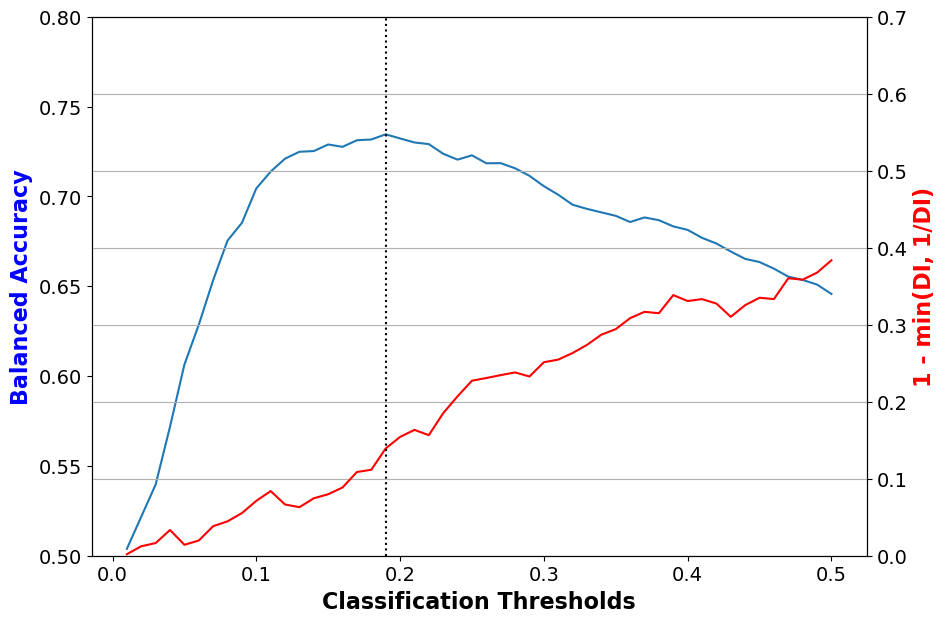

In [85]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

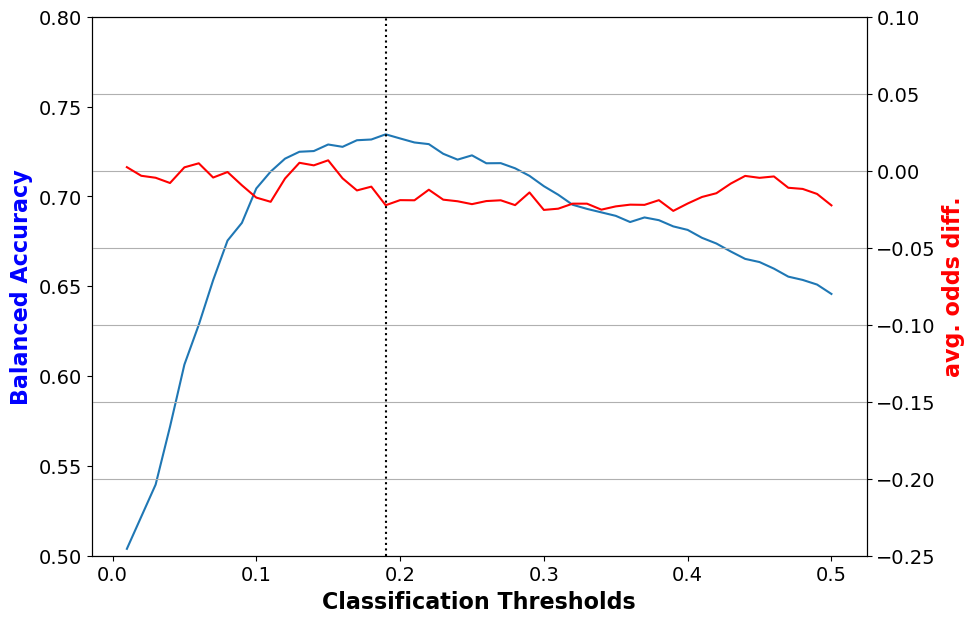

In [86]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [87]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7345
Corresponding 1-min(DI, 1/DI) value: 0.1393
Corresponding average odds difference value: -0.0224
Corresponding statistical parity difference value: -0.0534
Corresponding equal opportunity difference value: -0.0549
Corresponding Theil index value: 0.0998


In [88]:
lr_transf_metrics_panel20_test = test(
        dataset=dataset_orig_panel20_test,
        model=lr_transf_panel20,
        thresh_arr=[thresh_arr[lr_transf_best_ind_panel20]])

In [89]:
describe_metrics(lr_transf_metrics_panel20_test, [thresh_arr[lr_transf_best_ind_panel20]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7366
Corresponding 1-min(DI, 1/DI) value: 0.1131
Corresponding average odds difference value: 0.0269
Corresponding statistical parity difference value: -0.0413
Corresponding equal opportunity difference value: 0.0607
Corresponding Theil index value: 0.0959


The new model is both relatively fair as well as accurate so we deploy and test against the 2016 deployment data

### 9.3. Testing model learned on 2015 (Panel 20) data on 2016 (Panel 21) deployment data

**Evaluate new 2015 transformed data model and evaluate again on 2016 deployment data**

In [90]:
lr_transf_panel20_metrics_panel21_deploy = test(
        dataset=dataset_orig_panel21_deploy,
        model=lr_transf_panel20,
        thresh_arr=[thresh_arr[lr_transf_best_ind_panel20]])

In [91]:
describe_metrics(lr_transf_panel20_metrics_panel21_deploy, [thresh_arr[lr_transf_best_ind_panel20]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7399
Corresponding 1-min(DI, 1/DI) value: 0.1836
Corresponding average odds difference value: -0.0046
Corresponding statistical parity difference value: -0.0703
Corresponding equal opportunity difference value: 0.0025
Corresponding Theil index value: 0.0953


The new transformed 2016 data model is again within original accuracy/fairness specs so is deployed

## [10.](#Table-of-Contents) SUMMARY

In [92]:
results = [lr_orig_metrics, lr_transf_metrics,
           lr_transf_metrics_panel20_deploy,
           lr_transf_metrics_panel21_deploy,
           lr_transf_metrics_panel20_test,
           lr_transf_panel20_metrics_panel21_deploy]
debias = pd.Series([''] + ['Reweighing']*5, name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*6, name='Classifier')
tr = pd.Series(['Panel19']*4 + ['Panel20']*2, name='Training set')
te = pd.Series(['Panel19']*2 + ['Panel20', 'Panel21']*2, name='Testing set')
pd.concat([pd.DataFrame(m) for m in results], axis=0).set_index([debias, clf, tr, te])

,,,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,Training set,Testing set,,,,,,
,Logistic Regression,Panel19,Panel19,0.775935,-0.205706,0.426176,-0.261207,-0.222779,0.092122
Reweighing,Logistic Regression,Panel19,Panel19,0.753893,-0.015104,0.751755,-0.087196,-0.003518,0.096575
Reweighing,Logistic Regression,Panel19,Panel20,0.731136,0.007135,0.805724,-0.059602,0.030262,0.101910
Reweighing,Logistic Regression,Panel19,Panel21,0.737916,-0.014340,0.744126,-0.081262,-0.004405,0.099420
Reweighing,Logistic Regression,Panel20,Panel20,0.736636,0.026886,0.886936,-0.041285,0.060663,0.095898
Reweighing,Logistic Regression,Panel20,Panel21,0.739882,-0.004606,0.816441,-0.070348,0.002486,0.095346
